# Advanced Model Evaluation Lab

In [41]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

So far, we have been using logistic regression for binary problems where there are only two class labels. As you might have suspected or read in the documentation, logistic regression can be extended to dependent variables with multiple classes.
We are using the gridsearch in conjunction with multinomial logistic to optimize a model that predicts the category (type) of crime based on various features captured by San Francisco police departments.


### Part 1: Load in the Data and Check for Categorical Variables. 

In [42]:
df = pd.read_csv('sf_crime_train.csv')

In [43]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,5/13/15 23:53,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,5/13/15 23:53,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,5/13/15 23:33,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,5/13/15 23:30,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,5/13/15 23:30,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [44]:
df.describe()

,X,Y
count,18000.000000,18000.000000
mean,-122.423639,37.768466
std,0.026532,0.024391
min,-122.513642,37.708154
25%,-122.434199,37.753838
50%,-122.416949,37.775608
75%,-122.406539,37.785390
max,-122.365565,37.819923


### Part 2: Do Some Exploratory Analysis

Plot some of the data, check the variable types, and check if variables are correlated. (For the latter, you can use `.corr()`  )

In [45]:
df.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [46]:
df.isnull().sum()
#No nulls to deal with - yay!

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [47]:
for item in df:
    print item
    print df[item].nunique()
    print df[item].nunique()/float(len(df))
    
#Dates - 44% unique, useful anyway - need to convert to datetime
#Category - Worth keeping (may want to group small percentages into 'other')
#Descript - High variance, but may be useful if grouping within Categories
#Day of Week - Keep, may need to make integer 
#PdDistrict - Keep, may need to make dummy variables (non-ordinal) - Patsy may work for this
#Resolution - Keep, may need to make dummy variables (non-ordinal) - Patsy may work for this
#Address - Very high variance, can drop
#X/Y - Lat/Long. - high variance but meaningful as numbers - keep

Dates
7855
0.436388888889
Category
36
0.002
Descript
510
0.0283333333333
DayOfWeek
7
0.000388888888889
PdDistrict
10
0.000555555555556
Resolution
10
0.000555555555556
Address
6381
0.3545
X
6806
0.378111111111
Y
6823
0.379055555556


In [48]:
#Dates - convert to datetime
df.Dates = pd.to_datetime(df.Dates)

In [49]:
#Category - useful, may want to group counts below certain threshold as 'other'
#we already have a class for this - 'OTHER OFFENSES' - making up 12% of the data
#Let's say we only want the top 5 classes - everything else can go in 'OTHER OFFENSES'
#We can group any classes with <1% occurence into this class.
counts = df.Category.value_counts()/len(df)

#define a subset of the 5 most common categories
subset = ['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT', 'VEHICLE THEFT']
def group_low_freq(x):
    if x not in subset:
        return 'OTHER OFFENSES'
    else:
        return x
    
df['Category'] = df.Category.apply(group_low_freq)
df.Category.value_counts()

OTHER OFFENSES    8355
LARCENY/THEFT     4885
NON-CRIMINAL      2255
ASSAULT           1538
VEHICLE THEFT      967
Name: Category, dtype: int64

In [50]:
#Descript - has high variance, but may be useful within each category
df.Descript.value_counts()

#Many of these values appear to have a single instance, and it would be an in depth analysis to group them. 
#We will drop it for now, but remember to come back to it if we want to do deeper analysis.
df.drop('Descript', inplace=True, axis=1)

In [51]:
df.DayOfWeek.value_counts()

Wednesday    2930
Friday       2733
Saturday     2556
Thursday     2479
Sunday       2456
Monday       2447
Tuesday      2399
Name: DayOfWeek, dtype: int64

In [52]:
#Day of Week - Keep this. We can map the days of the week to integers, because although they are technically
#nominal classes (not ordinal), they do represent progress through the week (ie a higher number means later in the week)
#so we can make these numbers.

#Debate on this decision is welcome!

weekdays = {'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}
df['Weekday'] = df.DayOfWeek.map(weekdays)
df.drop('DayOfWeek', inplace=True, axis=1)

In [53]:
#Drop address - high variance, X/Y coordinates take place of location descriptor
df.drop('Address', inplace=True, axis=1)

In [54]:
df

,Dates,Category,PdDistrict,Resolution,X,Y,Weekday
0,2015-05-13 23:53:00,OTHER OFFENSES,NORTHERN,"ARREST, BOOKED",-122.425892,37.774599,3
1,2015-05-13 23:53:00,OTHER OFFENSES,NORTHERN,"ARREST, BOOKED",-122.425892,37.774599,3
2,2015-05-13 23:33:00,OTHER OFFENSES,NORTHERN,"ARREST, BOOKED",-122.424363,37.800414,3
3,2015-05-13 23:30:00,LARCENY/THEFT,NORTHERN,NONE,-122.426995,37.800873,3
4,2015-05-13 23:30:00,LARCENY/THEFT,PARK,NONE,-122.438738,37.771541,3
5,2015-05-13 23:30:00,LARCENY/THEFT,INGLESIDE,NONE,-122.403252,37.713431,3
6,2015-05-13 23:30:00,VEHICLE THEFT,INGLESIDE,NONE,-122.423327,37.725138,3
7,2015-05-13 23:30:00,VEHICLE THEFT,BAYVIEW,NONE,-122.371274,37.727564,3
8,2015-05-13 23:00:00,LARCENY/THEFT,RICHMOND,NONE,-122.508194,37.776601,3
9,2015-05-13 23:00:00,LARCENY/THEFT,CENTRAL,NONE,-122.419088,37.807802,3


### Utilize Patsy to create your X and Y variables

If you're having trouble with patsy formulas, read more at http://patsy.readthedocs.io/en/latest/formulas.html

In [65]:
import patsy

#make a new object called 'data' that sets our y (target) as Category and the other features we like as X
#Note that the 'C' before the feature name indicates that it's categorical. Its absence indicates continues variables.

X = patsy.dmatrix('~ C(PdDistrict) + C(Resolution) + C(Weekday)', df)

#We need to convert our dmatrix back into a data frame to use the methods we're used to
#It would be okay to use get_dummies instead of patsy, it just requires more typing

X = pd.DataFrame(X, columns=X.design_info.column_names)

In [66]:
X

,Intercept,C(PdDistrict)[T.CENTRAL],C(PdDistrict)[T.INGLESIDE],C(PdDistrict)[T.MISSION],C(PdDistrict)[T.NORTHERN],C(PdDistrict)[T.PARK],C(PdDistrict)[T.RICHMOND],C(PdDistrict)[T.SOUTHERN],C(PdDistrict)[T.TARAVAL],C(PdDistrict)[T.TENDERLOIN],...,C(Resolution)[T.NONE],C(Resolution)[T.NOT PROSECUTED],C(Resolution)[T.PSYCHOPATHIC CASE],C(Resolution)[T.UNFOUNDED],C(Weekday)[T.1],C(Weekday)[T.2],C(Weekday)[T.3],C(Weekday)[T.4],C(Weekday)[T.5],C(Weekday)[T.6]
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [67]:
#Rather than make y values part of our dmatrix, we can keep y as a series
y = df['Category'].values

### Part 3: Split data randomly into datasets, 70% train, 30% test using test train split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)

### Part 4: Initialize and Fit the Model (Either SKLearn or Statsmodels is acceptable) and make your predictions

In [69]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Part 5: Check the evaluation metrics for your Logistic Regression

**Hint**: Use what you've learned this morning from Joseph!

Specifically: 
- Classification Report
- Confusion Matrix
- ROC/AUC

In [70]:
model.score(X_test,y_test)

0.54259259259259263

In [71]:
#get predictions to compare with true y values
y_pred = model.predict(X_test)

In [72]:
#Classification report:
from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

    ASSAULT       0.00      0.00      0.00       471
LARCENY/THEFT       0.48      0.67      0.56      1635
NON-CRIMINAL       0.49      0.07      0.12       736
OTHER OFFENSES       0.58      0.75      0.66      2757
VEHICLE THEFT       0.00      0.00      0.00       341

avg / total       0.46      0.54      0.47      5940



/Users/boyan/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [85]:
#Confusion Matrix:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns=(model.classes_ + ' PREDICTED'), index=(model.classes_ + ' TRUE'))
cm

,ASSAULT PREDICTED,LARCENY/THEFT PREDICTED,NON-CRIMINAL PREDICTED,OTHER OFFENSES PREDICTED,VEHICLE THEFT PREDICTED
ASSAULT TRUE,0,130,3,338,0
LARCENY/THEFT TRUE,0,1098,0,537,0
NON-CRIMINAL TRUE,0,308,51,377,0
OTHER OFFENSES TRUE,0,640,43,2074,0
VEHICLE THEFT TRUE,0,112,7,222,0


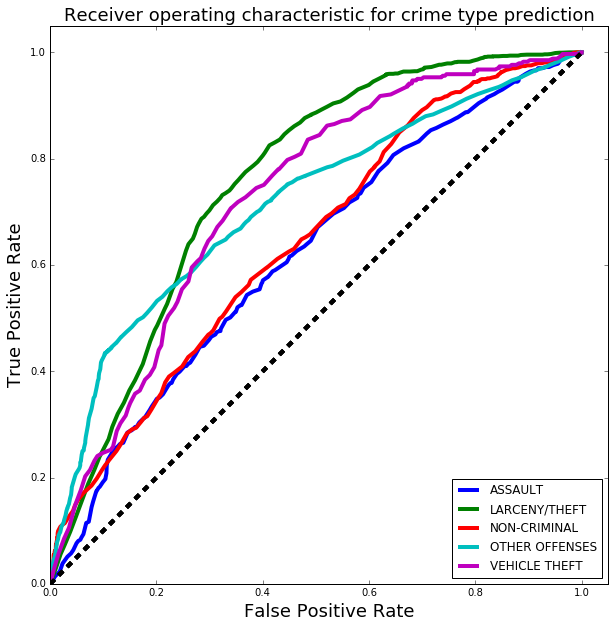

In [74]:
#ROC/AUC graphs:
from sklearn.metrics import roc_curve, auc

#Remember, these graph probabilities of our predictions
#we can use the .decision_function method of LogisticRegression() to get the array representing this
y_score = model.decision_function(X_test)

#Since our y has multiple classes (in this solution, 5), we need to reduce the scope of our roc curve
#Typically roc is meant to predict binary results
#We can solve it by iterating through the y_score array
#The columns of y_score represent the different classes, and the rows represent the probabilities of the target result given by each row
#We need to take each column of y_score, one at a time, to plot roc curves

#create dictionaries to track results
FPR = {}
TPR = {}
ROC_AUC = {}
labels = []

#set up plot space
plt.figure(figsize=[10,10])
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for crime type prediction', fontsize=18)

#create a function that will iterate through a multi-class output y_score
def roc_auc_vis(y_score):
    for i in range(y_score.shape[1]):

        #define which class we're looking at
        crime_type = model.classes_[i]

        #calculate the false positive rate and true positive rate using 'roc_curve' on
        #our true values (y_test) and the probabilities (y_score column for that crime type)
        
        #instead of converting to dummy variables, we can define the 'pos_label' as the class we're looking at
        #this will make the roc_curve look for that class as 'True' and all other values as 'False'
        FPR[i], TPR[i], _ = roc_curve(y_test, y_score[:,i], pos_label=crime_type)
        
        #with 'auc', calculate the auc using the FPR and TRP we just got
        ROC_AUC[i] = auc(FPR[i], TPR[i])
        
        #plot our roc curve
        labels.append(crime_type)
        plt.plot(FPR[i], TPR[i], label=crime_type % ROC_AUC[i], linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
        
        plt.legend(loc='lower right')
        
roc_auc_vis(y_score)

### Part 6: Utilize Gridsearch to check for optimal parameters

Remember for Gridsearch, we want to define the parameter grid. We can initilize the search parameters with:

In [75]:
search_parameters = {}
#We can also just input the dictionary directly into the parameters for our gridsearch, done below

For now, focus on giving Gridsearch different parameters and different penalities, where `C_vals =` something and `penalties = ` something

In [89]:
from sklearn.grid_search import GridSearchCV

#list the possible parameters for our model type (logistic regression) that we want gridsearch to check

#solver?

#see the documentation for all the parameters we can tune:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# C : Inverse of regularization strength; must be a positive float, smaller values specify stronger regularization.
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]

# penalty : str, ‘l1’ or ‘l2’; specify the norm used in the penalization
penalties = ['l1','l2']

#create the gridsearch, using the parameter lists defined above
#note that CV stands for cross-validation, so we're inherently cross-validating our dataset
#this allows us to fit it to the whole data set, without worrying about the train-test-split
gs = GridSearchCV(model, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X, y)

KeyboardInterrupt: 

#### What were the best parameters?

In [ ]:
gs.best_params_

#### Run your model again, this time inputting the best parameters that gridsearch found

In [ ]:
best_model = LogisticRegression(C=0.5, penalty='l2')

In [ ]:
best_model.fit(X_train,y_train)

In [ ]:
best_y_pred = best_model.predict(X_test)

#### Did the model's performance improve? How do we know? 

In [93]:
#Classification report:
cm = classification_report(y_test, y_pred)

pd.DataFrame(cm)

PandasError: DataFrame constructor not properly called!

In [208]:
best_model.score(X_test,y_test)

0.54309764309764308

In [ ]:
#improved only negligibly given these features